# Creating a Tag Tag network

retrieving tags from the posts table 

explaination of tags field and PostTypeId https://meta.stackexchange.com/questions/199724/posts-xml-doesnt-contain-tags-information 

Questions will have the Tags attribute, Answers won't.


- `PostTypeId="1"` denotes questions, those rows do have a Tags attribute. 

- `PostTypeId="2"` denote answers, those rows lack the Tags attribute but they do have a ParentId attribute that links the answer to its question.


Full listing of [PostTypeIds](https://meta.stackexchange.com/questions/99265/meaning-of-values-for-posttypeid-in-data-explorer-or-in-data-dump): 
```
        1 Question
        2 Answer
        3 Wiki
        4 TagWikiExcerpt
        5 TagWiki
        6 ModeratorNomination
        7 WikiPlaceholder
        8 PrivilegeWiki
```

other references: https://www.python-course.eu/graphs_python.php



In [1]:
import pandas as pd

In [5]:
fields=['Id','PostTypeId','ParentId','Tags']
df = pd.read_csv('data/gaming/csv/Posts.csv', usecols=fields)
df.head()

,Id,PostTypeId,ParentId,Tags
0,1,1,NaN,<team-fortress-2>
1,2,1,NaN,<starcraft-2><starcraft-protoss>
2,3,1,NaN,<steam><source-engine>
3,4,1,NaN,<the-secret-of-monkey-island>
4,6,1,NaN,<backwards-compatibility><windows-xp><sam-and-...


In [8]:
df.PostTypeId.value_counts()

2    148943
1     89943
5      3596
4      3596
6        81
3        19
7         5
Name: PostTypeId, dtype: int64

In [24]:
dfQuestions = df[df.PostTypeId == 1][['Id','PostTypeId','Tags']]
dfQuestions.PostTypeId.value_counts()

1    89943
Name: PostTypeId, dtype: int64

In [26]:
dfQuestions.head()

,Id,PostTypeId,Tags
0,1,1,<team-fortress-2>
1,2,1,<starcraft-2><starcraft-protoss>
2,3,1,<steam><source-engine>
3,4,1,<the-secret-of-monkey-island>
4,6,1,<backwards-compatibility><windows-xp><sam-and-...


In [32]:
print('counts:\n', dfQuestions.count(),'\n')
print('missing values %:\n', dfQuestions.isna().sum()/(len(dfQuestions))*100)

counts:
 Id            89943
PostTypeId    89943
Tags          89943
dtype: int64 

missing values %:
 Id            0.0
PostTypeId    0.0
Tags          0.0
dtype: float64


# split the tags and start creating tag tag data set

use a regular expression to capture vales  in sequence of <tag1>..<tagn> and return a list of tag values
```python
import re

str1 = '<distributions><normality-assumption>'
pattern = '\<([^\>]*)\>'
tags1  = re.findall(pattern=pattern, string=str1)
```

In [166]:
import re

pattern = '\<([^\>]*)\>'
dfQuestions['TagsList'] = dfQuestions.Tags.str.findall(pat=pattern)
dfQuestions.TagsList = dfQuestions['TagsList'].apply(lambda l: sorted(l)) # ensuring tags list is sorted, important for creating edge combinations
dfQuestions['TagsCount'] = dfQuestions.TagsList.apply(len)
dfQuestions['EdgesCount'] = (dfQuestions['TagsCount'] * (dfQuestions['TagsCount']-1)/2).astype(int)
print(dfQuestions.TagsCount.value_counts())

1    68239
2    17600
3     3423
4      604
5       77
Name: TagsList, dtype: int64


In [167]:
dfQuestions['TagsList'].apply(lambda l: sorted(l))

0                                         [team-fortress-2]
1                          [starcraft-2, starcraft-protoss]
2                                    [source-engine, steam]
3                             [the-secret-of-monkey-island]
4         [backwards-compatibility, sam-and-max, windows...
                                ...                        
246174                             [grand-theft-auto-5, pc]
246175                           [zelda-breath-of-the-wild]
246177                           [zelda-breath-of-the-wild]
246179                         [the-elder-scrolls-5-skyrim]
246180                             [minecraft-java-edition]
Name: TagsList, Length: 89943, dtype: object

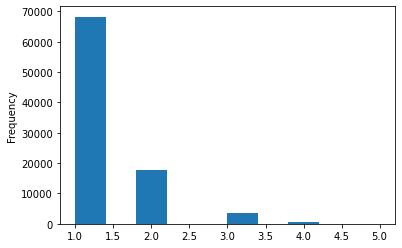

In [168]:
dfQuestions.TagsCount.plot.hist()

In [169]:
#dfQuestions[['Id','TagsList']].explode('TagsList')

In [170]:
tagslist = ['T2', 'T1', 'T3', 'T4', 'T5']
nodes_stack = list(tagslist)

n = len(tagslist)
n_edges = int(n*(n-1)/2)

print(f'nodes: {n}, edges: {n_edges}')

# use itertools to generate all permutations of edges
# correct function to use is combinations 

nodes: 5, edges: 10


In [171]:
print(tagslist)
print(type(tagslist))

['T2', 'T1', 'T3', 'T4', 'T5']
<class 'list'>


In [172]:
tagslist.sort()

use `itertools` to generate all permutations of edges, the correct function to use is `combinations`. 

`combinations` returns r-length tupples in sorted order with no repeated element, while `permutations` returns repeated elements. 

```python
import itertools
[e for e in itertools.combinations(['a','b','c'],2)]

output: 
[('a', 'b'), ('a', 'c'), ('b', 'c')]
```

i probably dont need the exploded list


In [173]:
import itertools

In [174]:
dfQuestions50 = dfQuestions.head(50)

dfQuestions50['edges'] = dfQuestions50.TagsList.apply(lambda t: [e for e in itertools.combinations(t,2)])
dfQuestions50['edges_count'] = dfQuestions50.edges.apply(len)

In [175]:
dfQuestions50.head(10)

,Id,PostTypeId,Tags,TagsList,TagsCount,EdgesCount,edges,edges_count
0,1,1,<team-fortress-2>,[team-fortress-2],1,0,[],0
1,2,1,<starcraft-2><starcraft-protoss>,"[starcraft-2, starcraft-protoss]",2,1,"[(starcraft-2, starcraft-protoss)]",1
2,3,1,<steam><source-engine>,"[source-engine, steam]",2,1,"[(source-engine, steam)]",1
3,4,1,<the-secret-of-monkey-island>,[the-secret-of-monkey-island],1,0,[],0
4,6,1,<backwards-compatibility><windows-xp><sam-and-...,"[backwards-compatibility, sam-and-max, windows...",3,3,"[(backwards-compatibility, sam-and-max), (back...",3
7,18,1,<xbox-360>,[xbox-360],1,0,[],0
11,25,1,<ultima-5>,[ultima-5],1,0,[],0
17,33,1,<wasteland>,[wasteland],1,0,[],0
19,38,1,<plants-vs-zombies>,[plants-vs-zombies],1,0,[],0
20,39,1,<xbox-360>,[xbox-360],1,0,[],0


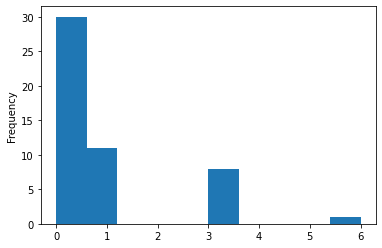

In [176]:
dfQuestions50.edges_count.plot.hist()

In [177]:
edges_exploded = dfQuestions50[['Id','edges']][dfQuestions50.edges_count>0].explode('edges')

In [178]:
edges_exploded.head(10)

,Id,edges
1,2,"(starcraft-2, starcraft-protoss)"
2,3,"(source-engine, steam)"
4,6,"(backwards-compatibility, sam-and-max)"
4,6,"(backwards-compatibility, windows-xp)"
4,6,"(sam-and-max, windows-xp)"
24,50,"(controllers, ps3)"
24,50,"(controllers, rock-band)"
24,50,"(ps3, rock-band)"
30,68,"(mario-series, new-super-mario-bros-wii)"
31,69,"(fallout, fallout-2)"


In [179]:
edges_exploded['v1'], edges_exploded['v2'] = zip(*edges_exploded.edges)

In [180]:
edges_exploded

,Id,edges,v1,v2
1,2,"(starcraft-2, starcraft-protoss)",starcraft-2,starcraft-protoss
2,3,"(source-engine, steam)",source-engine,steam
4,6,"(backwards-compatibility, sam-and-max)",backwards-compatibility,sam-and-max
4,6,"(backwards-compatibility, windows-xp)",backwards-compatibility,windows-xp
4,6,"(sam-and-max, windows-xp)",sam-and-max,windows-xp
24,50,"(controllers, ps3)",controllers,ps3
24,50,"(controllers, rock-band)",controllers,rock-band
24,50,"(ps3, rock-band)",ps3,rock-band
30,68,"(mario-series, new-super-mario-bros-wii)",mario-series,new-super-mario-bros-wii
31,69,"(fallout, fallout-2)",fallout,fallout-2


# summary 

exploded list can now be used to create a network tags with edges where tags appear in the same question 

we could here group by and count edge combinations to create weigted edges


In [221]:
edges_grouped = edges_exploded[['Id','edges']].groupby(['edges']).count().reset_index().rename(columns={'Id':'weight'})

In [223]:
edges_grouped['v1'], edges_grouped['v2'] = zip(*edges_grouped['edges'])

In [224]:
edges_grouped


,edges,weight,v1,v2
0,"(achievements, facebook)",1,achievements,facebook
1,"(achievements, mafia-wars)",1,achievements,mafia-wars
2,"(achievements, steam)",2,achievements,steam
3,"(achievements, torchlight)",1,achievements,torchlight
4,"(achievements, xbox-live)",1,achievements,xbox-live
5,"(aion, everquest)",1,aion,everquest
6,"(backwards-compatibility, sam-and-max)",1,backwards-compatibility,sam-and-max
7,"(backwards-compatibility, windows-xp)",1,backwards-compatibility,windows-xp
8,"(controllers, macos)",1,controllers,macos
9,"(controllers, pc)",1,controllers,pc


In [225]:
edges_grouped.to_csv('data/outputs/tags-tags.csv', index=False )